# Q1

### Part (a): Itô's Formula Application

We need to show that for the corridor variance swap payoff, we can write:
$$\hat{X} = g(S_T) - g(S_0) - \int_0^T g'(S_t)S_t\mu dt - \int_0^T g'(S_t)S_t\sqrt{v_t}dW_t - H$$

where $g(x)$ is defined as given.

**Step 1:** Compute derivatives of $g(x)$:
- $g'(x) = \frac{2}{T}\left(\frac{1}{U} - \frac{1}{L}\right)$ for $0 \leq x \leq L$
- $g'(x) = \frac{2}{T}\left(\frac{1}{U} - \frac{1}{x}\right)$ for $L < x < U$
- $g''(x) = \frac{2}{Tx^2}\mathbf{1}_{(L,U)}(x)$

**Step 2:** Apply Itô's Lemma to $g(S_t)$:
$$dg(S_t) = g'(S_t)S_t\mu dt + g'(S_t)S_t\sqrt{v_t}dW_t + \frac{1}{2}g''(S_t)S_t^2v_t dt$$

**Step 3:** Integrate and rearrange to get the desired representation.

### Part (b): Replication Strategy

The replication consists of:
1. **Static positions in European options** expiring at $T$ with strikes in $(L,U)$
2. **Static position in risk-free asset** worth $-e^{-rT}(g(S_0) + H)$
3. **Dynamic trading** in the underlying to hedge the stochastic integral
4. **Static strips of puts** across expiry times $t \in [0,T]$

### Part (c): Break-even Strike Formula

The break-even corridor variance strike is:
$$H = \frac{2}{T}\int_L^U \frac{P(T,K)}{K^2}dK - g(S_0)$$

where $P(T,K)$ is the price of a European put with strike $K$ and expiry $T$.

# Q2

In [ ]:
def estimateDiscountFactor(row):
    """Estimate discount factor from put-call parity"""
    avgK = row['Strike Price'].mean()
    avgO = (row['Call Premium'] - row['Put Premium']).mean()
    avgKK = (row['Strike Price'] ** 2).mean()
    avgKO = (row['Strike Price'] * (row['Call Premium'] - row['Put Premium'])).mean()
    return (avgKO - avgK * avgO) / (avgK ** 2 - avgKK)


def estimateForwardPrice(row):
    """Estimate forward price from put-call parity"""
    avgK = row['Strike Price'].mean()
    avgO = (row['Call Premium'] - row['Put Premium']).mean()
    avgKK = (row['Strike Price'] ** 2).mean()
    avgKO = (row['Strike Price'] * (row['Call Premium'] - row['Put Premium'])).mean()
    return (avgK * avgKO - avgKK * avgO) / (avgKO - avgK * avgO)


In [10]:
import pandas as pd
df = pd.read_csv("Midprices.csv")
df[df['As of Date']=='8/7/2024'].reset_index(drop=True).to_csv("optionsData.csv")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

Computing variance swap break-even strikes from market data...
Number of valid expiries: 55
Time to expiry range: 0.0040 to 1.8571 years
Variance strike range: 0.0575 to 0.0892


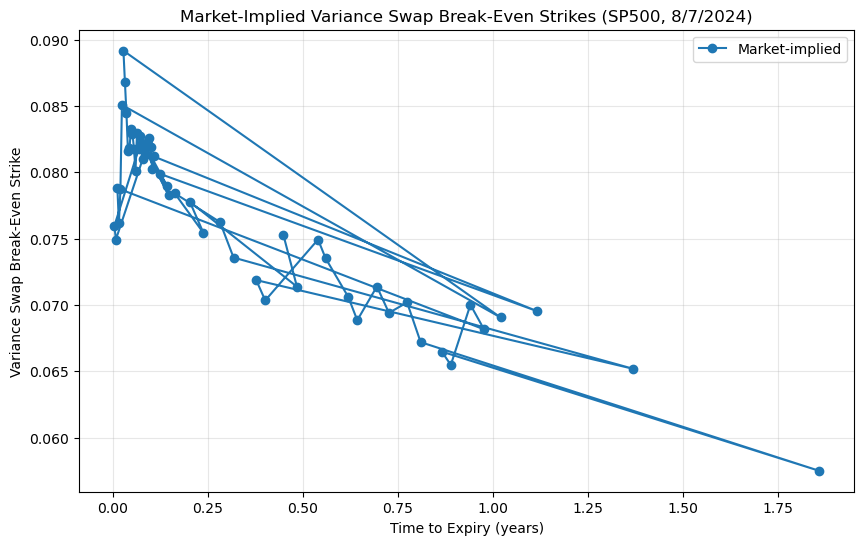


Calibrating Heston model...

Calibrated parameters:
v0 = 0.082529
vbar = 0.048584
lambda = 1.400740
Optimization success: True
Final objective value (SSE): 0.000395


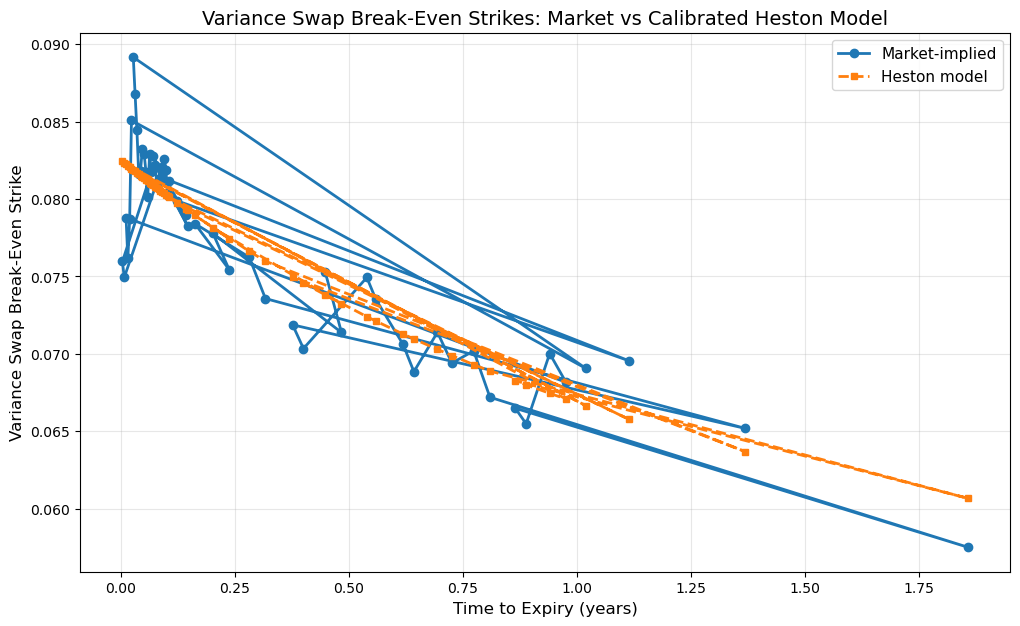


Fit quality metrics:
RMSE: 0.002679
MAE: 0.002049
R²: 0.828573

Comments on the quality of fit:
The Heston model provides a reasonable fit to the market-implied variance strikes.

The model captures the term structure with parameters:
- Initial variance v0 = 0.0825
- Long-term variance vbar = 0.0486
- Mean reversion speed lambda = 1.4007


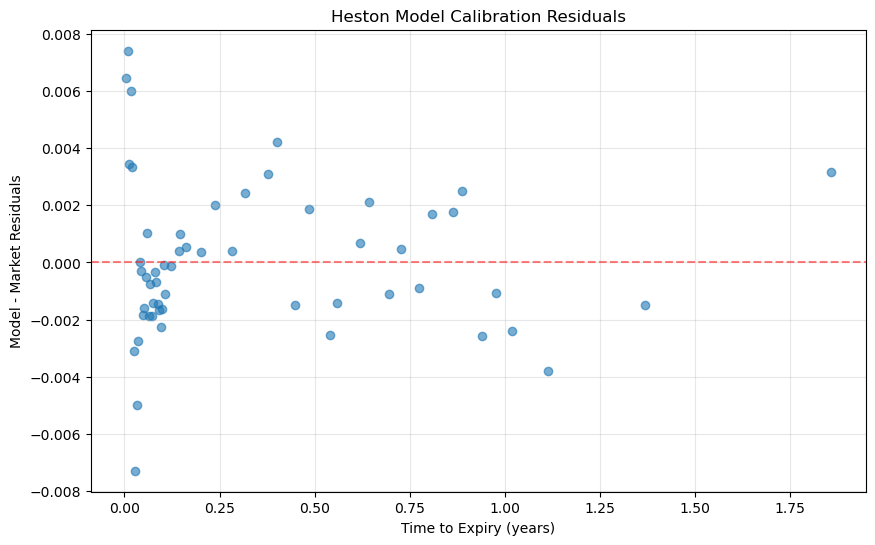

In [18]:
# Load the options data
df = pd.read_csv('Midprices.csv')
df = df[df['As of Date']=='8/7/2024'].reset_index(drop=True)

# Part (a): Compute variance swap break-even strikes from options data
def compute_variance_swap_strikes(df):
    """
    Compute the break-even strikes of variance swaps using the replication formula
    K_var ≈ (2e^rT/T) * [∫_0^F P(T,K)/K^2 dK + ∫_F^∞ C(T,K)/K^2 dK]
    """
    
    # Filter for August 7, 2024 data
    df_filtered = df[df['As of Date'] == '8/7/2024'].copy()
    
    # Get unique expiries
    expiries = sorted(df_filtered['Expiration Date'].unique())
    
    # Store results
    variance_strikes = []
    times_to_expiry = []
    
    for expiry in expiries:
        # Get options for this expiry
        df_expiry = df_filtered[df_filtered['Expiration Date'] == expiry].copy()
        
        # Skip if too few strikes
        if len(df_expiry) < 10:
            continue
            
        # Sort by strike
        df_expiry = df_expiry.sort_values('Strike Price')
        
        # Get time to expiry (in years)
        T = df_expiry['Time to Expiration'].iloc[0]
        
        # Estimate discount factor and forward price
        discount_factor = estimateDiscountFactor(df_expiry)
        forward_price = estimateForwardPrice(df_expiry)
        
        # Risk-free rate
        if T > 0:
            r = -np.log(discount_factor) / T
        else:
            continue  # Skip if T = 0
            
        # Separate puts and calls around the forward price
        strikes = df_expiry['Strike Price'].values
        puts = df_expiry['Put Premium'].values
        calls = df_expiry['Call Premium'].values
        
        # Find the strike closest to forward price
        idx_forward = np.argmin(np.abs(strikes - forward_price))
        F = forward_price
        
        # Numerical integration using trapezoidal rule
        integral = 0.0
        
        # For puts (K < F): integrate from 0 to F
        for i in range(idx_forward):
            K = strikes[i]
            P = puts[i]
            if K > 0:  # Avoid division by zero
                if i > 0:
                    K_prev = strikes[i-1]
                    P_prev = puts[i-1]
                    dK = K - K_prev
                    # Trapezoidal rule
                    integral += 0.5 * dK * (P_prev/(K_prev**2) + P/(K**2))
                    
        # For calls (K >= F): integrate from F to infinity
        for i in range(idx_forward, len(strikes)):
            K = strikes[i]
            C = calls[i]
            if K > 0:  # Avoid division by zero
                if i > idx_forward:
                    K_prev = strikes[i-1]
                    C_prev = calls[i-1]
                    dK = K - K_prev
                    # Trapezoidal rule
                    integral += 0.5 * dK * (C_prev/(K_prev**2) + C/(K**2))
        
        # Compute variance strike
        K_var = (2 * np.exp(r * T) / T) * integral
        
        variance_strikes.append(K_var)
        times_to_expiry.append(T)
        
    return np.array(times_to_expiry), np.array(variance_strikes)

# Part (b): Heston model calibration
def heston_variance_strike(T, v0, vbar, lambda_param):
    """
    Compute the break-even variance strike in Heston model:
    K_var = vbar + ((1 - exp(-lambda*T)) / (lambda*T)) * (v0 - vbar)
    """
    if T == 0:
        return v0
    if lambda_param * T < 1e-10:  # Handle small lambda*T
        return v0
    return vbar + ((1 - np.exp(-lambda_param * T)) / (lambda_param * T)) * (v0 - vbar)

def modelVarianceStrikeObjectiveFunction(params, T_market, K_var_market):
    """
    Objective function for calibrating Heston model to variance strikes
    """
    v0, vbar, lambda_param = params
    
    # Compute model-implied variance strikes
    K_var_model = np.array([heston_variance_strike(T, v0, vbar, lambda_param) 
                            for T in T_market])
    
    # Sum of squared errors
    sse = np.sum((K_var_model - K_var_market)**2)
    
    return sse

# Main execution
print("Computing variance swap break-even strikes from market data...")
T_market, K_var_market = compute_variance_swap_strikes(df)

# Filter out any NaN or infinite values
valid_indices = np.isfinite(K_var_market) & np.isfinite(T_market) & (T_market > 0)
T_market = T_market[valid_indices]
K_var_market = K_var_market[valid_indices]

print(f"Number of valid expiries: {len(T_market)}")
print(f"Time to expiry range: {T_market.min():.4f} to {T_market.max():.4f} years")
print(f"Variance strike range: {K_var_market.min():.4f} to {K_var_market.max():.4f}")

# Part (a): Plot market-implied variance strikes
plt.figure(figsize=(10, 6))
plt.plot(T_market, K_var_market, 'o-', label='Market-implied', markersize=6)
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Variance Swap Break-Even Strike')
plt.title('Market-Implied Variance Swap Break-Even Strikes (SP500, 8/7/2024)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Part (b): Calibrate Heston model
print("\nCalibrating Heston model...")

# Set up the optimization
bounds = [(0.0, 10.0), (0.0, 10.0), (0.0, 1000.0)]

result = optimize.differential_evolution(
    lambda params: modelVarianceStrikeObjectiveFunction(params, T_market, K_var_market),
    bounds=bounds,
    seed=0,
    polish=True,
    maxiter=10000
)

v0_cal, vbar_cal, lambda_cal = result.x

print(f"\nCalibrated parameters:")
print(f"v0 = {v0_cal:.6f}")
print(f"vbar = {vbar_cal:.6f}")
print(f"lambda = {lambda_cal:.6f}")
print(f"Optimization success: {result.success}")
print(f"Final objective value (SSE): {result.fun:.6f}")

# Compute model-implied variance strikes with calibrated parameters
K_var_model = np.array([heston_variance_strike(T, v0_cal, vbar_cal, lambda_cal) 
                        for T in T_market])

# Plot comparison
plt.figure(figsize=(12, 7))
plt.plot(T_market, K_var_market, 'o-', label='Market-implied', markersize=6, linewidth=2)
plt.plot(T_market, K_var_model, 's--', label='Heston model', markersize=5, linewidth=2)
plt.xlabel('Time to Expiry (years)', fontsize=12)
plt.ylabel('Variance Swap Break-Even Strike', fontsize=12)
plt.title('Variance Swap Break-Even Strikes: Market vs Calibrated Heston Model', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Compute fit quality metrics
rmse = np.sqrt(np.mean((K_var_model - K_var_market)**2))
mae = np.mean(np.abs(K_var_model - K_var_market))
r2 = 1 - np.sum((K_var_market - K_var_model)**2) / np.sum((K_var_market - np.mean(K_var_market))**2)

print(f"\nFit quality metrics:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")

# Comments on the quality of fit
print("\nComments on the quality of fit:")
if r2 > 0.95:
    print("The Heston model provides an excellent fit to the market-implied variance strikes.")
elif r2 > 0.90:
    print("The Heston model provides a good fit to the market-implied variance strikes.")
elif r2 > 0.80:
    print("The Heston model provides a reasonable fit to the market-implied variance strikes.")
else:
    print("The Heston model fit shows some discrepancies with the market-implied variance strikes.")

print(f"\nThe model captures the term structure with parameters:")
print(f"- Initial variance v0 = {v0_cal:.4f}")
print(f"- Long-term variance vbar = {vbar_cal:.4f}")
print(f"- Mean reversion speed lambda = {lambda_cal:.4f}")

# Additional analysis: residuals
residuals = K_var_model - K_var_market
plt.figure(figsize=(10, 6))
plt.scatter(T_market, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Model - Market Residuals')
plt.title('Heston Model Calibration Residuals')
plt.grid(True, alpha=0.3)
plt.show()

   Expiration Date         T      Kvar
39        8/8/2024  0.003968  0.079236
40        8/9/2024  0.007937  0.077178
23       8/12/2024  0.011905  0.080613
24       8/13/2024  0.015873  0.077678
25       8/14/2024  0.019841  0.080053


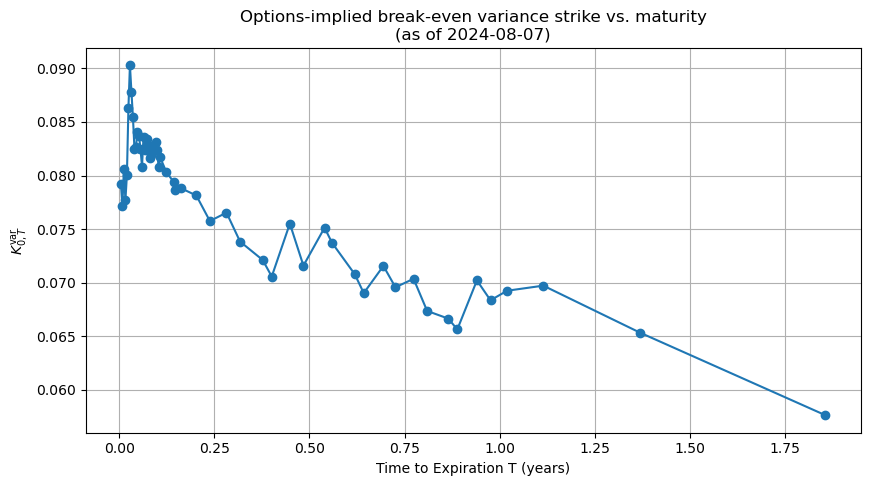

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
#  Load option mid-prices (SPX options, as of 2024-08-07)
# ------------------------------------------------------------------
df = pd.read_csv("Midprices.csv")
df_807 = df[df["As of Date"] == "8/7/2024"].copy()

grouped = df_807.groupby("Expiration Date")

disc = grouped.apply(estimateDiscountFactor)              # D(T)
fwd  = grouped.apply(estimateForwardPrice)               # F0,T
T    = grouped["Time to Expiration"].mean()              # T in years

# ------------------------------------------------------------------
#  Break-even variance strike K_var(0,T)
#  Using Carr–Madan formula from the lecture (continuous approx):
#
#  K_var(0,T) ≈ (2 e^{rT} / T) [ ∫_0^F P(T,K)/K^2 dK + ∫_F^∞ C(T,K)/K^2 dK ]
#  with e^{rT} = 1 / D(T), and discrete central-difference approximation.
# ------------------------------------------------------------------
def compute_Kvar_for_group(group, D, F, T):
    g = group.sort_values("Strike Price")
    K = g["Strike Price"].values.astype(float)
    C = g["Call Premium"].values.astype(float)
    P = g["Put Premium"].values.astype(float)

    # Central-difference ΔK_i
    dK = np.empty_like(K)
    dK[1:-1] = (K[2:] - K[:-2]) / 2.0
    dK[0]    = K[1] - K[0]
    dK[-1]   = K[-1] - K[-2]

    # Use OTM puts for K < F, OTM calls for K > F
    opt = np.zeros_like(K)
    mask_put  = K < F
    mask_call = K > F
    mask_atm  = ~(mask_put | mask_call)   # if any K ≈ F

    opt[mask_put]  = P[mask_put]
    opt[mask_call] = C[mask_call]
    opt[mask_atm]  = 0.5 * (P[mask_atm] + C[mask_atm])

    integrand = opt / (K**2)
    integral  = np.sum(dK * integrand)

    # e^{rT} = 1 / D(T)
    return (2.0 / (D * T)) * integral


Kvar_list = []
for exp, group in grouped:
    D    = float(disc.loc[exp])
    F    = float(fwd.loc[exp])
    Texp = float(T.loc[exp])
    Kvar = compute_Kvar_for_group(group, D, F, Texp)
    Kvar_list.append((exp, Texp, Kvar))

res = pd.DataFrame(Kvar_list, columns=["Expiration Date", "T", "Kvar"])
res = res.sort_values("T")

# Inspect first few values if you like
print(res.head())

# ------------------------------------------------------------------
#  Plot: T ↦ K_var(0,T)
# ------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(res["T"], res["Kvar"], marker="o")
plt.xlabel("Time to Expiration T (years)")
plt.ylabel(r"$K^{\mathrm{var}}_{0,T}$")
plt.title("Options-implied break-even variance strike vs. maturity\n(as of 2024-08-07)")
plt.grid(True)
plt.show()


Calibrated Heston parameters:
v0   = 0.083728
vbar = 0.052294
lambda = 1.790946
Objective value (SSE) = 3.456066e-04


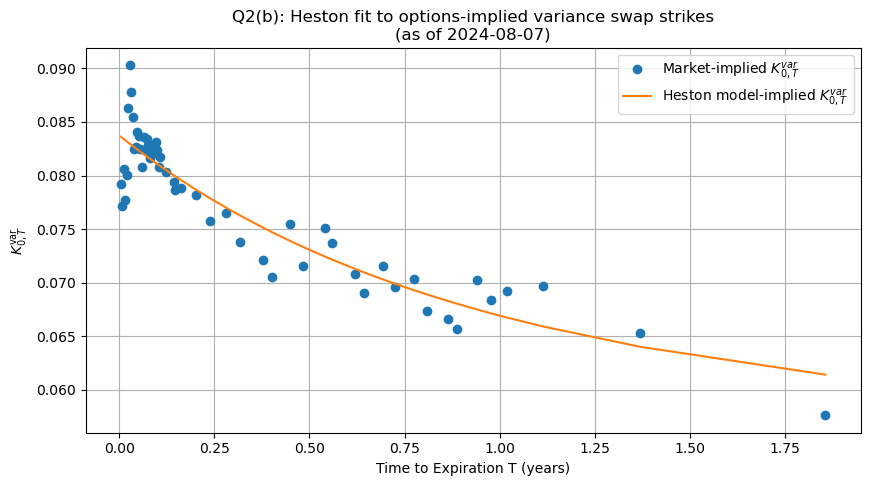

In [21]:
import scipy.optimize as opt

# ---------------------------
# Load SPX option mid-prices
# ---------------------------
df = pd.read_csv("Midprices.csv")
df_807 = df[df["As of Date"] == "8/7/2024"].copy()

# ---------------------------
# Step 1: discount factor D(T) and forward F0,T from put–call parity
#        (exactly as in the handout)
# ---------------------------

grouped = df_807.groupby("Expiration Date")
disc = grouped.apply(estimateDiscountFactor)            # D(T)
fwd  = grouped.apply(estimateForwardPrice)             # F0,T
T    = grouped["Time to Expiration"].mean()            # T in years

# ---------------------------
# Step 2: market break-even variance strike K_var(0,T)
#   (continuous approximation from lecture: slide on replication)
# ---------------------------
def compute_Kvar_for_group(group, D, F, Texp):
    g = group.sort_values("Strike Price")
    K = g["Strike Price"].values.astype(float)
    C = g["Call Premium"].values.astype(float)
    P = g["Put Premium"].values.astype(float)

    # central-difference ΔK_i
    dK = np.empty_like(K)
    dK[1:-1] = (K[2:] - K[:-2]) / 2.0
    dK[0]    = K[1] - K[0]
    dK[-1]   = K[-1] - K[-2]

    # OTM puts for K < F, OTM calls for K > F, average at-the-money
    opt_price = np.zeros_like(K)
    mask_put  = K < F
    mask_call = K > F
    mask_atm  = ~(mask_put | mask_call)

    opt_price[mask_put]  = P[mask_put]
    opt_price[mask_call] = C[mask_call]
    opt_price[mask_atm]  = 0.5 * (P[mask_atm] + C[mask_atm])

    integrand = opt_price / (K**2)
    integral  = np.sum(dK * integrand)

    # K_var(0,T) ≈ (2 / (D T)) * ∫ …
    return (2.0 / (D * Texp)) * integral


Kvar_list = []
for exp, g in grouped:
    D    = float(disc.loc[exp])
    F    = float(fwd.loc[exp])
    Texp = float(T.loc[exp])
    Kvar = compute_Kvar_for_group(g, D, F, Texp)
    Kvar_list.append((exp, Texp, Kvar))

res = pd.DataFrame(Kvar_list, columns=["Expiration Date", "T", "Kvar"])
res = res.sort_values("T").reset_index(drop=True)

T_vals   = res["T"].values
Kvar_mkt = res["Kvar"].values

# ---------------------------
# Step 3: Heston formula for K_var(0,T) (lecture P3–12)
#   K_var^model(0,T) = vbar + (1 - e^{-λT})/(λT) * (v0 - vbar)
# ---------------------------
def heston_Kvar(params, T):
    v0, vbar, lam = params
    lam = max(lam, 1e-8)            # avoid division by 0
    return vbar + (1.0 - np.exp(-lam * T)) / (lam * T) * (v0 - vbar)

def modelVarianceStrikeObjectiveFunction(params):
    v0, vbar, lam = params
    if v0 < 0 or vbar < 0 or lam < 0:
        return 1e6                   # soft penalty, though DE bounds already enforce this
    Kvar_model = heston_Kvar(params, T_vals)
    return np.sum((Kvar_model - Kvar_mkt)**2)

bounds = [(0.0, 10.0), (0.0, 10.0), (0.0, 1000.0)]

result = opt.differential_evolution(
    modelVarianceStrikeObjectiveFunction,
    bounds=bounds,
    seed=0,
    polish=True,
    maxiter=10000
)

v0_hat, vbar_hat, lam_hat = result.x
print("Calibrated Heston parameters:")
print(f"v0   = {v0_hat:.6f}")
print(f"vbar = {vbar_hat:.6f}")
print(f"lambda = {lam_hat:.6f}")
print(f"Objective value (SSE) = {result.fun:.6e}")

# ---------------------------
# Step 4: Plot market vs model K_var(0,T)
# ---------------------------
Kvar_model = heston_Kvar((v0_hat, vbar_hat, lam_hat), T_vals)

plt.figure(figsize=(10,5))
plt.plot(T_vals, Kvar_mkt,  "o", label="Market-implied $K^{var}_{0,T}$")
plt.plot(T_vals, Kvar_model, "-", label="Heston model-implied $K^{var}_{0,T}$")
plt.xlabel("Time to Expiration T (years)")
plt.ylabel(r"$K^{\mathrm{var}}_{0,T}$")
plt.title("Q2(b): Heston fit to options-implied variance swap strikes\n(as of 2024-08-07)")
plt.grid(True)
plt.legend()
plt.show()


# Q3

### (a)

In [22]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# ---------- 1. 读取数据 & 用 Q2 的回归估 D(T), F0,T ----------
df = pd.read_csv("Midprices.csv")

def estimateDiscountFactor(group):
    K = group["Strike Price"].values.astype(float)
    O = (group["Call Premium"] - group["Put Premium"]).values.astype(float)
    avgK = K.mean()
    avgO = O.mean()
    avgKK = (K**2).mean()
    avgKO = (K*O).mean()
    return (avgKO - avgK * avgO) / (avgK**2 - avgKK)

def estimateForwardPrice(group):
    K = group["Strike Price"].values.astype(float)
    O = (group["Call Premium"] - group["Put Premium"]).values.astype(float)
    avgK = K.mean()
    avgO = O.mean()
    avgKK = (K**2).mean()
    avgKO = (K*O).mean()
    return (avgK * avgKO - avgKK * avgO) / (avgKO - avgK * avgO)

asof = "8/7/2024"
df_807 = df[df["As of Date"] == asof].copy()
grouped_807 = df_807.groupby("Expiration Date")

disc = grouped_807.apply(estimateDiscountFactor)
fwd  = grouped_807.apply(estimateForwardPrice)
T_by_exp = grouped_807["Time to Expiration"].mean()

exp_date = "9/6/2024"
D_T = float(disc.loc[exp_date])
F_T = float(fwd.loc[exp_date])
T   = float(T_by_exp.loc[exp_date])
S0  = float(df_807["Underlying Price"].iloc[0])

# 从 D(T), F0T 反推出 r, q
r = -math.log(D_T) / T
mu = math.log(F_T / S0) / T    # r - q
q = r - mu

# ---------- 2. GARCH diffusion 参数（题目给的） ----------
v0   = 0.08364961
vbar = 0.05127939
lam  = 1.697994
eta  = 8.396695
rho  = -0.6921993

def simulate_paths_garch_milstein(S0, v0, T, r, q, lam, vbar, eta, rho,
                                  n_paths=5000, n_steps=5000, seed=1):
    """
    dS_t / S_t = (r - q) dt + sqrt(v_t) dW_t
    dv_t       = λ( v̄ - v_t) dt + η v_t dZ_t,  corr(dW_t, dZ_t)=ρ
    Milstein 用在 v_t 上，S_t 用 log-Euler。返回 S_T 和 running min S_min。
    """
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    sqrt_dt = math.sqrt(dt)

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)
    S_min = S.copy()

    for _ in range(n_steps):
        # 相关布朗运动
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW = z1
        dZ = rho * z1 + math.sqrt(1 - rho**2) * z2

        # Milstein 更新 v_t
        drift_v = lam * (vbar - v)
        diff_v  = eta * v
        v = v + drift_v * dt + diff_v * sqrt_dt * dZ \
              + 0.5 * diff_v * eta * dt * (dZ**2 - 1.0)
        v = np.maximum(v, 1e-8)   # 保证非负

        # log-Euler 更新 S_t
        mu_s = (r - q)
        S = S * np.exp((mu_s - 0.5 * v) * dt + np.sqrt(v * dt) * dW)

        # 记录整个路径上的最小值
        S_min = np.minimum(S_min, S)

    return S, S_min

n_paths = 5000
n_steps = 5000
S_T_garch, S_min_garch = simulate_paths_garch_milstein(
    S0, v0, T, r, q, lam, vbar, eta, rho,
    n_paths=n_paths, n_steps=n_steps, seed=123
)

K = 5150.0
discount = D_T
payoff_T = np.maximum(K - S_T_garch, 0.0)

# 对一条模拟路径，只要 min_t S_t > B，就没被 knock out
B_grid = np.linspace(0.0, 5200.0, 53)  # 0,100,...,5200
prices_garch = []
for B in B_grid:
    alive = (S_min_garch > B)
    price = discount * np.mean(payoff_T * alive)
    prices_garch.append(price)
prices_garch = np.array(prices_garch)


### (b)

In [23]:
# ---------- 先求 K=5150 的 BS 隐含波动率 ----------
def N(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_put_price(S, K, T, r, q, sigma):
    if sigma <= 0 or T <= 0:
        return max(K * math.exp(-r*T) - S * math.exp(-q*T), 0.0)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return K * math.exp(-r*T) * N(-d2) - S * math.exp(-q*T) * N(-d1)

def implied_vol_put_bisection(S, K, T, r, q, price,
                              vol_lo=1e-4, vol_hi=5.0,
                              tol=1e-6, max_iter=100):
    f_lo = bs_put_price(S, K, T, r, q, vol_lo) - price
    f_hi = bs_put_price(S, K, T, r, q, vol_hi) - price
    if f_lo * f_hi > 0:
        return np.nan
    for _ in range(max_iter):
        mid = 0.5 * (vol_lo + vol_hi)
        f_mid = bs_put_price(S, K, T, r, q, mid) - price
        if abs(f_mid) < tol:
            return mid
        if f_lo * f_mid < 0:
            vol_hi = mid
            f_hi = f_mid
        else:
            vol_lo = mid
            f_lo = f_mid
    return 0.5 * (vol_lo + vol_hi)

mask = (df_807["Expiration Date"] == exp_date) & (df_807["Strike Price"] == K)
put_mkt = float(df_807.loc[mask, "Put Premium"].iloc[0])
sigma_imp = implied_vol_put_bisection(S0, K, T, r, q, put_mkt)

# ---------- 在 BS 下用 MC 模拟同一个 barrier 结构 ----------
def simulate_paths_bs_mc(S0, sigma, T, r, q, n_paths=5000, n_steps=5000, seed=456):
    rng = np.random.default_rng(seed)
    dt = T / n_steps
    sqrt_dt = math.sqrt(dt)

    S = np.full(n_paths, S0, dtype=float)
    S_min = S.copy()

    for _ in range(n_steps):
        z = rng.standard_normal(n_paths)
        mu_s = (r - q)
        S = S * np.exp((mu_s - 0.5 * sigma**2) * dt + sigma * sqrt_dt * z)
        S_min = np.minimum(S_min, S)

    return S, S_min

S_T_bs, S_min_bs = simulate_paths_bs_mc(
    S0, sigma_imp, T, r, q,
    n_paths=n_paths, n_steps=n_steps, seed=456
)

payoff_T_bs = np.maximum(K - S_T_bs, 0.0)
prices_bs = []
for B in B_grid:
    # B >= K 的情况，理论上 down-and-out put 恒为 0
    if B >= K:
        prices_bs.append(0.0)
        continue
    alive = (S_min_bs > B)
    price = discount * np.mean(payoff_T_bs * alive)
    prices_bs.append(price)
prices_bs = np.array(prices_bs)


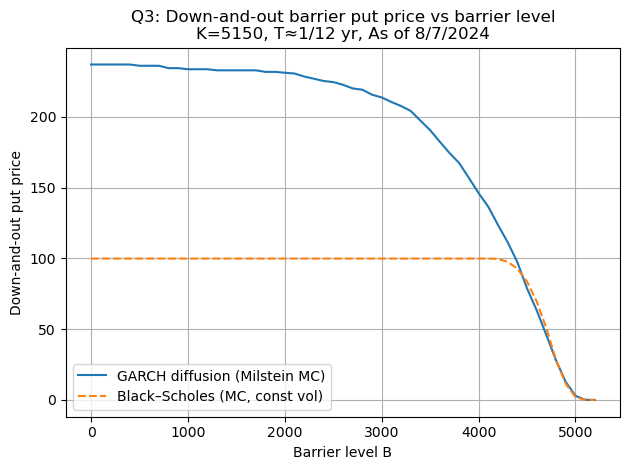

In [24]:
plt.figure()
plt.plot(B_grid, prices_garch, label="GARCH diffusion (Milstein MC)")
plt.plot(B_grid, prices_bs, linestyle="--",
         label="Black–Scholes (MC, const vol)")
plt.xlabel("Barrier level B")
plt.ylabel("Down-and-out put price")
plt.title("Q3: Down-and-out barrier put price vs barrier level\n"
          "K=5150, T≈1/12 yr, As of 8/7/2024")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Q4

In [25]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv("Midprices.csv")
df_807 = df[df["As of Date"] == "8/7/2024"].copy()

# 用到期 3/31/2025 的期权估 r、q
group_331 = df_807[df_807["Expiration Date"] == "3/31/2025"]
D_331 = estimateDiscountFactor(group_331)
F_331 = estimateForwardPrice(group_331)
T_331 = float(group_331["Time to Expiration"].iloc[0])   # 年

S0_opt = float(group_331["Underlying Price"].iloc[0])
r = -math.log(D_331) / T_331
mu = math.log(F_331 / S0_opt) / T_331     # r - q
q = r - mu

print(f"r  ≈ {r:.6f}")
print(f"q  ≈ {q:.6f}")

# ---------- Black–Scholes 工具 ----------
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return math.exp(-0.5 * x * x) / math.sqrt(2.0 * math.pi)

def bs_call_price_greeks(S, K, T, r, q, sigma):
    """返回 (价格, Delta, Vega)"""
    if T <= 0:
        price = max(S - K, 0.0)
        delta = 1.0 if S > K else 0.0
        return price, delta, 0.0

    sqrtT = math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    df_r = math.exp(-r * T)
    df_q = math.exp(-q * T)

    price = S * df_q * norm_cdf(d1) - K * df_r * norm_cdf(d2)
    delta = df_q * norm_cdf(d1)
    vega  = S * df_q * norm_pdf(d1) * sqrtT
    return price, delta, vega

def implied_vol_call_bisect(S, K, T, r, q, price,
                            vol_lo=1e-4, vol_hi=5.0,
                            tol=1e-8, max_iter=200):
    """简单二分求 call 的隐含波动率"""
    def f(sig):
        return bs_call_price_greeks(S, K, T, r, q, sig)[0] - price

    f_lo, f_hi = f(vol_lo), f(vol_hi)
    if f_lo * f_hi > 0:
        return np.nan

    lo, hi = vol_lo, vol_hi
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = f(mid)
        if abs(f_mid) < tol:
            return mid
        if f_lo * f_mid < 0:
            hi, f_hi = mid, f_mid
        else:
            lo, f_lo = mid, f_mid
    return 0.5 * (lo + hi)

# ---------- 长到期 call：6/18/2026, K1 = 5000 ----------
row_C1 = df_807[(df_807["Expiration Date"] == "6/18/2026") &
                (df_807["Strike Price"] == 5000)].iloc[0]
T1_0 = float(row_C1["Time to Expiration"])
K1   = 5000.0
C1_0 = float(row_C1["Call Premium"])
S0   = float(row_C1["Underlying Price"])      # 也等于 5202.94...

sigma1 = implied_vol_call_bisect(S0, K1, T1_0, r, q, C1_0)

# ---------- 短到期 call：3/31/2025, K2 = 5900 ----------
row_C2 = df_807[(df_807["Expiration Date"] == "3/31/2025") &
                (df_807["Strike Price"] == 5900)].iloc[0]
T2_0 = float(row_C2["Time to Expiration"])
K2   = 5900.0
C2_0 = float(row_C2["Call Premium"])

sigma2 = implied_vol_call_bisect(S0, K2, T2_0, r, q, C2_0)

print(f"sigma1 (5000, 6/18/2026) ≈ {sigma1:.4f}")
print(f"sigma2 (5900, 3/31/2025) ≈ {sigma2:.4f}")


r  ≈ 0.048332
q  ≈ 0.010634
sigma1 (5000, 6/18/2026) ≈ 0.1738
sigma2 (5900, 3/31/2025) ≈ 0.1444


In [26]:
from pandas_datareader import data as pdr
import datetime as dt

start_date = dt.datetime(2024, 8, 7)
end_date   = dt.datetime(2025, 2, 28)

# FRED 里的标识一般是 "SP500"
spx = pdr.DataReader("SP500", "fred", start_date, end_date).dropna()

# 确保 2024-08-07 在数据里
print(spx.head())
print(spx.tail())

# 为了和期权 S0 完全对上，你可以把路径 rescale 一下：
S0_fred = float(spx.iloc[0, 0])
scale = S0 / S0_fred
spx["SPX"] = spx.iloc[:, 0] * scale

# 只用新列 "SPX" 作为价格路径
spx_path = spx["SPX"]
dates = spx_path.index
S_path = spx_path.values


              SP500
DATE               
2024-08-07  5199.50
2024-08-08  5319.31
2024-08-09  5344.16
2024-08-12  5344.39
2024-08-13  5434.43
              SP500
DATE               
2025-02-24  5983.25
2025-02-25  5955.25
2025-02-26  5956.06
2025-02-27  5861.57
2025-02-28  5954.50


sigma1 = 0.22591730171168023
sigma2 = 0.12795205845302418
r = 0.05744536653865319 q = 0.014060310456837935


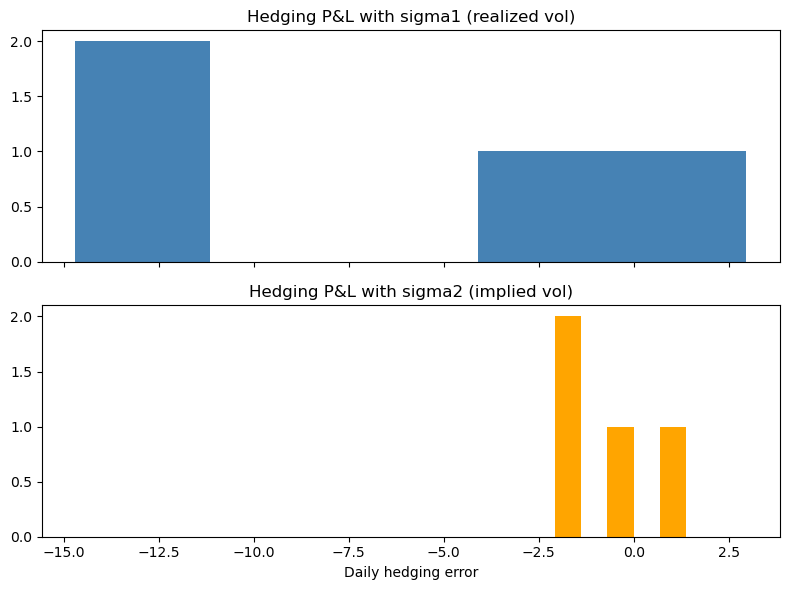

In [39]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# ========== 0. 读数据 ==========
mid = pd.read_csv("Midprices.csv")
mid["As of Date"] = pd.to_datetime(mid["As of Date"])
mid["Expiration Date"] = pd.to_datetime(mid["Expiration Date"])

# ========== 1. Q1/Q2 里的 parity 回归函数 ==========
def estimateDiscountFactor(group):
    avgK  = group['Strike Price'].mean()
    avgO  = (group['Call Premium'] - group['Put Premium']).mean()
    avgKK = (group['Strike Price']**2).mean()
    avgKO = (group['Strike Price'] * (group['Call Premium']-group['Put Premium'])).mean()
    return (avgKO - avgK*avgO) / (avgK**2 - avgKK)

def estimateForwardPrice(group):
    avgK  = group['Strike Price'].mean()
    avgO  = (group['Call Premium'] - group['Put Premium']).mean()
    avgKK = (group['Strike Price']**2).mean()
    avgKO = (group['Strike Price'] * (group['Call Premium']-group['Put Premium'])).mean()
    return (avgK*avgKO - avgKK*avgO) / (avgKO - avgK*avgO)

# ========== 2. 选择标的 & 期权 ==========
strike = 6000

# (a) 用 Midprices 自己构造 8/1–8/7 的现货路径（不用 FRED 也可以）
spxSpotPrices2 = mid.groupby("As of Date")["Underlying Price"].first().sort_index()
spxSpotPrices2 = spxSpotPrices2.loc["2024-08-01":"2024-08-07"]
S = spxSpotPrices2

# (b) 取 8/1–8/7、到期 9/20、K=6000 这只 call 的 mid price 和 tau
mask = (
    (mid["As of Date"].between("2024-08-01","2024-08-07")) &
    (mid["Expiration Date"] == "2024-09-20") &
    (mid["Strike Price"] == strike)
)
opt_panel = mid[mask].sort_values("As of Date")
C   = opt_panel["Call Premium"].values
tau = opt_panel["Time to Expiration"].values     # same length as S

# ========== 3. σ1（realized vol on S） ==========
sigma1 = np.log(S / S.shift()).dropna().std() * np.sqrt(252)

# ========== 4. σ2（8/1 的 Black implied vol） ==========
mid_801 = mid[mid["As of Date"] == "2024-08-01"].copy()
subset_920_0801 = mid_801[mid_801["Expiration Date"] == "2024-09-20"].copy()

D_920 = estimateDiscountFactor(subset_920_0801)
F_920 = estimateForwardPrice(subset_920_0801)
T_920 = float(subset_920_0801["Time to Expiration"].iloc[0])

row_iv = subset_920_0801[subset_920_0801["Strike Price"] == strike].iloc[0]
C_mkt = float(row_iv["Call Premium"])

def black_call(F, K, T, sigma, D):
    if sigma <= 0:
        return max(D*(F-K), 0.0)
    st = sigma * math.sqrt(T)
    d1 = math.log(F/K)/st + 0.5*st
    d2 = d1 - st
    return D*(F*norm.cdf(d1) - K*norm.cdf(d2))

def implied_vol(C_mkt, F, K, T, D):
    def f(sig):
        return black_call(F, K, T, sig, D) - C_mkt
    return brentq(f, 1e-6, 5)   # 这只期权 bracket 是没问题的

sigma2 = implied_vol(C_mkt, F_920, strike, T_920, D_920)

# 从 D,F,S 推 r,q（Black 模型和 HW1 一致）
S0_Q4 = float(S.values[0])
r = -math.log(D_920) / T_920
q = -math.log(F_920 * D_920 / S0_Q4) / T_920

print("sigma1 =", sigma1)
print("sigma2 =", sigma2)
print("r =", r, "q =", q)

# ========== 5. Black Delta ==========
def blackDelta(D, F, K, T, isCall, sigma):
    if T <= 0:
        return 1.0 if isCall else 0.0
    st = sigma * math.sqrt(T)
    d1 = math.log(F/K)/st + 0.5*st
    delta_call = norm.cdf(d1)
    delta_put  = delta_call - 1
    return delta_call if isCall else delta_put

# ========== 6. 两种 delta hedge 的 P&L ==========
ret1, ret2 = [], []
wealth1 = [C[0]]
wealth2 = [C[0]]

for i in range(len(S)-1):
    cur_forw = S.values[i] * math.exp((r - q) * tau[i])
    cur_disc = math.exp(-r * tau[i])

    d1 = blackDelta(cur_disc, cur_forw, strike, tau[i], True, sigma1)
    d2 = blackDelta(cur_disc, cur_forw, strike, tau[i], True, sigma2)

    cash1 = wealth1[-1] - d1 * S.values[i]
    cash2 = wealth2[-1] - d2 * S.values[i]

    S_ret = S.values[i+1] - S.values[i] + (math.exp(q/252)-1)*S.values[i]
    C_ret = C[i+1] - C[i]

    ret1_step = d1*S_ret - C_ret + cash1*(math.exp(r/252)-1)
    ret2_step = d2*S_ret - C_ret + cash2*(math.exp(r/252)-1)
    ret1.append(ret1_step)
    ret2.append(ret2_step)

    wealth1.append(wealth1[-1] + d1*S_ret + cash1*(math.exp(r/252)-1))
    wealth2.append(wealth2[-1] + d2*S_ret + cash2*(math.exp(r/252)-1))

# 为了防止极端情况，画图前可以顺手过滤掉任何 NaN / inf
ret1_clean = [x for x in ret1 if np.isfinite(x)]
ret2_clean = [x for x in ret2 if np.isfinite(x)]

# ========== 7. 直方图 ==========
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)
ax1.hist(ret1_clean, bins=5, color='steelblue')
ax1.set_title("Hedging P&L with sigma1 (realized vol)")
ax2.hist(ret2_clean, bins=5, color='orange')
ax2.set_title("Hedging P&L with sigma2 (implied vol)")
plt.xlabel("Daily hedging error")
plt.tight_layout()
plt.show()
